Supponiamo che il cliente, una volta dopo aver alloggiato in albergo, voglia scegliere tra i tre ristoranti più vicini alla struttura in cui si trova, basandosi sulla sentiment analysis. Questi abbiamo visto essere: Caffè Le Rose, Giglio Rosso, Ristorante Sabatini.

In [1]:
import requests

url = "https://api.dandelion.eu/datatxt/sent/v1/"
token = "your-token-here"

ristoranti_recensioni = {
    "Trattoria La Madia": [
        "La classica trappola per turisti, esperienza da non ripetere.",
        "Atmosfera piacevole, ma i prezzi sono un po' alti.",
        "Qualità del cibo nella media, prezzo comprensibile trovandomi in centro.",
        "20 euro per due bevande sono troppi, almeno però il personale è gentile.",
        "Consiglio vivamente questo posto."
    ],
    "Ristorante Sabatini": [
        "Servizio veloce e amichevole, ottimo cibo e ottima carta dei vini",
        "Un'istituzione a Firenze, anche stasera esperienza positiva.",
        "Cibo fantastico!",
        "Andare qui è come sentirsi a casa",
        "Per me il miglior posto dove andare se ci si trova in centro."
    ],
    "Giglio Rosso": [
        "Molto sponsorizzato, non per questo non buono.",
        "Ottima carne e buon rapporto/qualità prezzo, per essere in centro.",
        "Molto soddisfacente nonostante l'arredamento antico.",
        "Una buona opzione se vuoi mangiare bene spendendo poco.",
        "I piatti erano saporiti, il servizio un po' lento. Ci tornerei."
    ]
}


results = []

#richiesta per ciascun ristorante e recensione
for ristorante, recensioni in ristoranti_recensioni.items():
    for review in recensioni:
        try:
            #richiesta a Dandelion API per l'analisi del sentiment
            payload = {
                "token": token,
                "text": review
            }
            response = requests.post(url, data=payload)
            
           
            result = response.json()["sentiment"]
            sentiment_score = result.get("score", "")
            sentiment_type = result.get("type", "")
            
        
            results.append({
                "restaurant_name": ristorante,
                "review": review,
                "sentiment_type": sentiment_type,
                "sentiment_score": sentiment_score
            })
        except Exception as e:
            print(f"Errore durante la richiesta API: {e}")


for result in results:
    print(f"Ristorante: {result['restaurant_name']}, Recensione: {result['review']}, Sentiment Type: {result['sentiment_type']}, Sentiment Score: {result['sentiment_score']}")



Ristorante: Trattoria La Madia, Recensione: La classica trappola per turisti, esperienza da non ripetere., Sentiment Type: negative, Sentiment Score: -0.85
Ristorante: Trattoria La Madia, Recensione: Atmosfera piacevole, ma i prezzi sono un po' alti., Sentiment Type: positive, Sentiment Score: 0.8
Ristorante: Trattoria La Madia, Recensione: Qualità del cibo nella media, prezzo comprensibile trovandomi in centro., Sentiment Type: neutral, Sentiment Score: 0.0
Ristorante: Trattoria La Madia, Recensione: 20 euro per due bevande sono troppi, almeno però il personale è gentile., Sentiment Type: positive, Sentiment Score: 0.8
Ristorante: Trattoria La Madia, Recensione: Consiglio vivamente questo posto., Sentiment Type: neutral, Sentiment Score: 0.0
Ristorante: Ristorante Sabatini, Recensione: Servizio veloce e amichevole, ottimo cibo e ottima carta dei vini, Sentiment Type: positive, Sentiment Score: 0.8333333333333334
Ristorante: Ristorante Sabatini, Recensione: Un'istituzione a Firenze, an

Risultati:
<div align="center">
    <img src="immagini/risultati_sa.png" width="1200" height="auto">

Dopo aver fatto un'opportuna scalatura di tali valori in una scala che va da 0 a 5 stelle, e aver fatto la media delle valutazioni di ognuno dei tre ristoranti, ho modificato i valori della colonna "Valutazione" nel CSV in _OpenRefine_.

In [2]:
import geopy.distance
import pandas as pd

#Nuovo csv
df = pd.read_csv("dataset/merge/Merged-with-sentimentanalysis.csv")

#Coordinate dell'hotel Universo
target_lat = 43.7740221
target_lon = 11.2499259
target = (target_lat, target_lon)

min_distance = float('inf')
nearest_location = None

top_locations = []

for index, row in df.iterrows():
    if row['Valutazione'] != 0 and row['Categoria'] in ['Ristorante', 'Bottege']:
        location_coords = (row['Latitudine'], row['Longitudine'])
        
        distance = geopy.distance.geodesic(target, location_coords).km

        if distance < min_distance:
            min_distance = distance
            nearest_location = row['Nome'], row['Latitudine'], row['Longitudine'], row['Valutazione']

        top_locations.append({
            'Nome': row['Nome'],
            'Distanza': distance,
            'Valutazione': row['Valutazione']
        })
top_locations = sorted(top_locations, key=lambda x: x['Distanza'])[:3]

#top 3 dei locali meno distanti
print("Top 3 Locali Meno Distanti:")
for loc in top_locations:
    print(f"Nome: {loc['Nome']}, Distanza: {loc['Distanza']} km, Valutazione: {loc['Valutazione']}")

#rapporto distanza/valutazione per ognuno dei tre locali
print("\nRapporto Distanza/Valutazione per i tre Locali:")
for loc in top_locations:
    ratio = loc['Distanza'] / loc['Valutazione']
    print(f"Nome: {loc['Nome']}, Rapporto: {ratio}")


Top 3 Locali Meno Distanti:
Nome: Ristorante Sabatini, Distanza: 0.07336347138349435 km, Valutazione: 3.6
Nome: Giglio Rosso, Distanza: 0.09940643977472921 km, Valutazione: 2.0
Nome: Trattoria La Madia, Distanza: 0.13128334050686882 km, Valutazione: 2.5

Rapporto Distanza/Valutazione per i tre Locali:
Nome: Ristorante Sabatini, Rapporto: 0.020378742050970653
Nome: Giglio Rosso, Rapporto: 0.049703219887364605
Nome: Trattoria La Madia, Rapporto: 0.05251333620274753


Visualizzazione grafica:

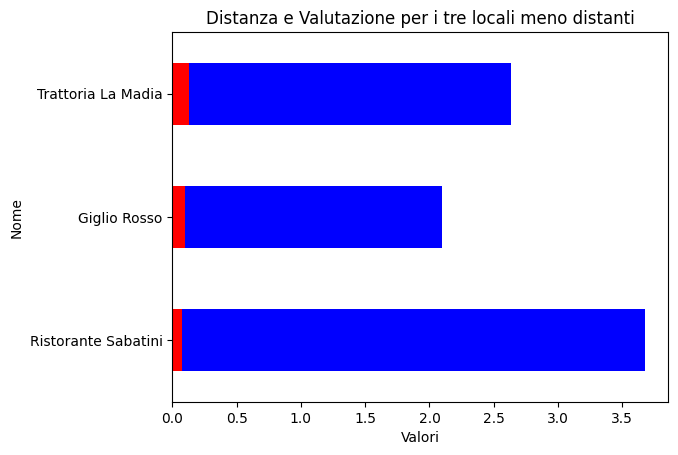

In [3]:
import matplotlib.pyplot as plt

plot_data = pd.DataFrame(top_locations, columns=['Nome', 'Distanza', 'Valutazione'])


plot_data['Rapporto'] = plot_data['Distanza'] / plot_data['Valutazione']

ax = plot_data.plot.barh(x='Nome', y=['Distanza', 'Valutazione'], stacked=True, color=['red', 'blue'], legend=False)
ax.set_xlabel('Valori')
ax.set_title('Distanza e Valutazione per i tre locali meno distanti')
plt.show()

_Disclaimer:
Le recensioni sono puramente fittizie e non vogliono in alcun modo corrispondere o fare riferimento alla realtà._